<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/02.%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%B0%BD%EC%8B%9C%EC%9E%90%EC%97%90%EA%B2%8C_%EB%B0%B0%EC%9A%B0%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D/6_4_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 세팅
---

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 794, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 794 (delta 222), reused 323 (delta 195), pack-reused 427
Receiving objects: 100% (794/794), 41.83 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (415/415), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

# 컨브넷을 사용한 시퀀스 처리

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 6장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.


## 1D 컨브넷 구현

케라스에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현합니다. `Conv1D`는 `Conv2D`와 인터페이스가 비슷합니다. `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용해 보죠.

기억을 되살리기 위해 데이터를 로드하고 전처리하는 코드를 다시 보겠습니다:

In [3]:
max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

imdb = tf.keras.datasets.imdb
print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


1D 컨브넷은 5장에서 사용한 2D 컨브넷과 비슷한 방식으로 구성합니다. `Conv1D`와 `MaxPooling1D` 층을 쌓고 전역 풀링 층이나 `Flatten` 층으로 마칩니다. 이 구조는 3D 입력을 2D 출력으로 바꾸므로 분류나 회귀를 위해 모델에 하나 이상의 `Dense` 층을 추가할 수 있습니다.

한 가지 다른 점은 1D 컨브넷에 큰 합성곱 윈도우를 사용할 수 있다는 것입니다. 2D 합성곱 층에서 3 × 3 합성곱 윈도우는 3 × 3 = 9 특성을 고려합니다. 하지만 1D 합성곱 층에서 크기 3인 합성곱 윈도우는 3개의 특성만 고려합니다. 그래서 1D 합성곱에 크기 7이나 9의 윈도우를 사용할 수 있습니다.

다음은 IMDB 데이터셋을 위한 1D 컨브넷의 예입니다:

In [9]:
x = layers.Input(shape = (max_len, ))
y = layers.Embedding(max_features, 128)(x)
y = layers.Conv1D(32,7, activation = 'relu')(y)
y = layers.MaxPool1D(5)(y)
y = layers.Conv1D(32,7, activation = 'relu')(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(1, activation = 'sigmoid')(y)  # 긍정/부정 클래스 예측

model = models.Model(x,y)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                  

Epoch 1/20
196/196 [==============================] - 16s 14ms/step - loss: 0.6902 - acc: 0.5700 - val_loss: 0.6825 - val_acc: 0.6812
Epoch 2/20
196/196 [==============================] - 2s 12ms/step - loss: 0.6543 - acc: 0.7248 - val_loss: 0.6168 - val_acc: 0.7572
Epoch 3/20
196/196 [==============================] - 2s 12ms/step - loss: 0.5513 - acc: 0.8010 - val_loss: 0.5020 - val_acc: 0.8172
Epoch 4/20
196/196 [==============================] - 2s 12ms/step - loss: 0.4321 - acc: 0.8495 - val_loss: 0.4102 - val_acc: 0.8428
Epoch 5/20
196/196 [==============================] - 3s 16ms/step - loss: 0.3533 - acc: 0.8732 - val_loss: 0.3642 - val_acc: 0.8567
Epoch 6/20
196/196 [==============================] - 3s 15ms/step - loss: 0.3085 - acc: 0.8876 - val_loss: 0.3389 - val_acc: 0.8670
Epoch 7/20
196/196 [==============================] - 2s 12ms/step - loss: 0.2790 - acc: 0.8976 - val_loss: 0.3263 - val_acc: 0.8722
Epoch 8/20
196/196 [==============================] - 2s 12ms/step -

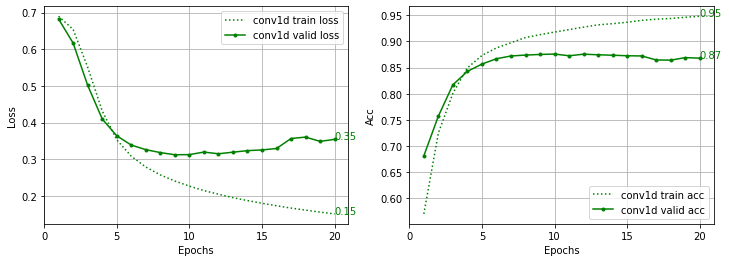

In [10]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 20,
                    batch_size = 128,
                    validation_data = (x_test, y_test))
plot_lcurve([history], ['conv1d'], ['g'], x_itv = 5)

그림 6-27과 6-28은 훈련과 검증 결과를 보여줍니다. 검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됩니다(속도 향상은 환경에 따라 많이 다릅니다). 여기에서 적절한 에포크 수(4개)로 모델을 다시 훈련하고 테스트 세트에서 확인할 수 있습니다. 이 예는 단어 수준의 감성 분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줍니다.

## CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 (합성곱 윈도우 크기의 범위를 넘어선) 타임스텝의 순서에 민감하지 않습니다. 물론 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다. 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다. 이런 방법은 순서를 감지하기엔 부족합니다. 온도 예측 문제에 1D 컨브넷을 적용하여 이를 확인해 보겠습니다. 이 문제는 순서를 감지해야 좋은 예측을 만들어 낼 수 있습니다. 다음은 이전에 정의한 float_data, train_gen, val_gen, val_steps를 다시 사용합니다:

이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다. 이 방법은 효과적이므로 많이 사용되기를 바랍니다. 온도 예측 문제에 적용해 보죠. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나(데이터 제너레이터의 `lookback` 매개변수를 증가시킵니다), 시계열 데이터를 더 촘촘히 바라볼 수 있습니다(제너레이터의 `step` 매개변수를 감소시킵니다). 여기서는 그냥 `step`을 절반으로 줄여서 사용하겠습니다. 온도 데이터가 30분마다 1 포인트씩 샘플링되기 때문에 결과 시계열 데이터는 두 배로 길어집니다. 앞서 정의한 제너레이터 함수를 다시 사용합니다.

이 모델은 두 개의 `Conv1D` 층 다음에 `GRU` 층을 놓았습니다:

검증 손실로 비교해 보면 이 설정은 규제가 있는 GRU 모델만큼 좋지는 않습니다. 하지만 훨씬 빠르기 때문에 데이터를 두 배 더 많이 처리할 수 있습니다. 여기서는 큰 도움이 안 되었지만 다른 데이터셋에서는 중요할 수 있습니다.

## 정리

다음은 이번 절에서 배운 것들입니다.

* 2D 컨브넷이 2D 공간의 시각적 패턴을 잘 처리하는 것과 같이 1D 컨브넷은 시간에 따른 패턴을 잘 처리합니다. 1D 컨브넷은 특정 자연어 처리 같은 일부 문제에 RNN을 대신할 수 있는 빠른 모델입니다.
* 전형적으로 1D 컨브넷은 컴퓨터 비전 분야의 2D 컨브넷과 비슷하게 구성합니다. `Conv1D` 층과 `Max-Pooling1D` 층을 쌓고 마지막에 전역 풀링 연산이나 `Flatten` 층을 둡니다.
* RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 많이 듭니다. 1D 컨브넷은 비용이 적게 듭니다. 따라서 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하는 것은 좋은 생각입니다. 시퀀스 길이를 줄이고 RNN이 처리할 유용한 표현을 추출해 줄 것입니다.

유용하고 중요한 개념이지만 여기서 다루지 않은 것은 팽창 커널을 사용한 1D 합성곱입니다.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_10 (Conv1D)          (None, 494, 32)           28704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 92, 32)            7200      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                           

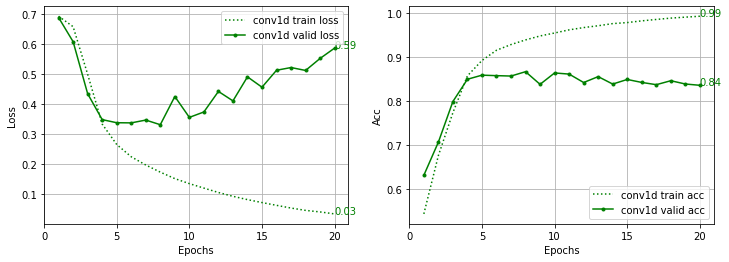

In [12]:
x = layers.Input(shape = (max_len, ))
y = layers.Embedding(max_features, 128)(x)
y = layers.Conv1D(32,7, activation = 'relu')(y)
y = layers.MaxPool1D(5)(y)
y = layers.Conv1D(32,7, activation = 'relu')(y)
y = layers.GRU(32,dropout = 0.2)(y)
y = layers.Dense(1, activation = 'sigmoid')(y)  # 긍정/부정 클래스 예측

model = models.Model(x,y)
model.summary()
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 20,
                    batch_size = 128,
                    validation_data = (x_test, y_test))
plot_lcurve([history], ['conv1d'], ['g'], x_itv = 5)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 500, 128)     1280000     ['input_10[0][0]']               
                                                                                                  
 conv1d_13 (Conv1D)             (None, 494, 32)      28704       ['embedding_9[0][0]']            
                                                                                                  
 conv1d_14 (Conv1D)             (None, 494, 32)      28704       ['embedding_9[0][0]']            
                                                                                            

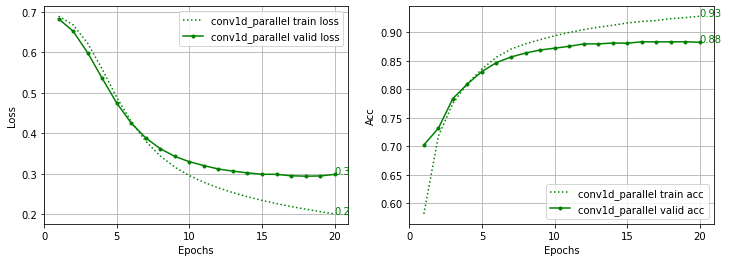

In [14]:
x = layers.Input(shape = (max_len, ))
y = layers.Embedding(max_features, 128)(x)

y1 = layers.Conv1D(32,7, activation = 'relu')(y)
y1= layers.MaxPool1D(5)(y1)

y2 = layers.Conv1D(32,7, activation = 'relu')(y)
y2 = layers.MaxPool1D(5)(y2)

y = layers.concatenate([y1,y2])
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(1, activation = 'sigmoid')(y)  # 긍정/부정 클래스 예측

model = models.Model(x,y)
model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 20,
                    batch_size = 128,
                    validation_data = (x_test, y_test))
plot_lcurve([history], ['conv1d_parallel'], ['g'], x_itv = 5)

## 시계열 데이터 분석
---

In [15]:
! git clone https://github.com/gilbutITbook/006975.git

Cloning into '006975'...
remote: Enumerating objects: 102534, done.
Receiving objects:  98% (101184/102534), 152.30 MiB | 16.89 MiB/s   
remote: Total 102534 (delta 0), reused 0 (delta 0), pack-reused 102534
Receiving objects: 100% (102534/102534), 202.75 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (104042/104042), done.


In [16]:
data_dir = '/content/006975/datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

for samples, targets in train_gen:
  print(samples.shape, targets.shape)
  break

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
(128, 240, 14) (128,)


In [94]:
max_len = len(float_data)
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

In [ ]:
float_data.

In [ ]:
# 교재 내용대로 모델 구성

In [91]:
from keras import optimizers


x = layers.Input(shape = (240,14))
y = layers.Conv1D(32,5, activation = 'relu')(x)
y = layers.MaxPooling1D(3)(y)
y = layers.Conv1D(32,5,activation = 'relu')(y)
y = layers.GRU(32, dropout=0.3, recurrent_dropout = 0.5)(y)
y = layers.Dense(1, activation = 'linear')(y)

model = models.Model(x,y)
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 240, 14)]         0         
                                                                 
 conv1d_74 (Conv1D)          (None, 236, 32)           2272      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 78, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_75 (Conv1D)          (None, 74, 32)            5152      
                                                                 
 gru_28 (GRU)                (None, 32)                6336      
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                          

In [122]:
def draw_mse(hist, x_itv) :
  for i, h in enumerate(hist) :
    hist_mse = h.history['mse']
    val_hist_mse = h.history['val_mse']
    epochs = range(1, 1+len(hist_mse))
    xbins = range(0, 1+len(hist_mse), x_itv)
    plt.plot(epochs, hist_mse, linestyle=':', label=f'train mse', c= 'g')
    plt.plot(epochs, val_hist_mse, marker='.', label=f'valid mse', c= 'g')
    plt.legend();plt.grid(True);plt.xticks(xbins)
    plt.xlabel('Epochs');plt.ylabel('mse')
    x, y = epochs[-1], h.history['mse'][-1]
    plt.text(x, y, np.round(y,2), c= 'g')
    x, y = epochs[-1], h.history['val_mse'][-1]
    plt.text(x, y, np.round(y,2), c= 'g')

In [117]:
epoch_step = len(lines) // batch_size
model.compile(loss= 'mse', optimizer= 'adam', metrics= ['mse'])
history = model.fit(train_gen,
                    epochs = 10,
                    steps_per_epoch = 50,
                    batch_size = 128,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/10
50/50 [==============================] - 39s 758ms/step - loss: 0.1735 - mse: 0.1735 - val_loss: 0.1587 - val_mse: 0.1587
Epoch 2/10
50/50 [==============================] - 34s 688ms/step - loss: 0.1688 - mse: 0.1688 - val_loss: 0.1426 - val_mse: 0.1426
Epoch 3/10
50/50 [==============================] - 34s 686ms/step - loss: 0.1662 - mse: 0.1662 - val_loss: 0.1512 - val_mse: 0.1512
Epoch 4/10
50/50 [==============================] - 34s 692ms/step - loss: 0.1617 - mse: 0.1617 - val_loss: 0.1511 - val_mse: 0.1511
Epoch 5/10
50/50 [==============================] - 34s 688ms/step - loss: 0.1613 - mse: 0.1613 - val_loss: 0.1557 - val_mse: 0.1557
Epoch 6/10
50/50 [==============================] - 34s 693ms/step - loss: 0.1587 - mse: 0.1587 - val_loss: 0.1511 - val_mse: 0.1511
Epoch 7/10
50/50 [==============================] - 34s 695ms/step - loss: 0.1576 - mse: 0.1576 - val_loss: 0.1460 - val_mse: 0.1460
Epoch 8/10
50/50 [==============================] - 34s 691ms/step - 

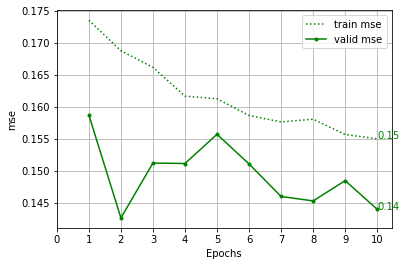

In [123]:
draw_mse([history], 1)

In [93]:
# 본인 모델 구성
x = layers.Input(shape = (240,14))
y1 = layers.Conv1D(32,5, activation = 'relu')(x)
y1 = layers.MaxPooling1D(3)(y1)

y2 = layers.Conv1D(32,5,activation = 'relu')(x)
y2 = layers.MaxPooling1D(3)(y2)

y = layers.concatenate([y1,y2])
y = layers.GlobalAveragePooling1D()(y)
y = layers.GRU(32, dropout=0.2, recurrent_dropout = 0.5)(y1)
y = layers.Dense(1, activation = 'linear')(y)

model = models.Model(x,y)
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 240, 14)]         0         
                                                                 
 conv1d_76 (Conv1D)          (None, 236, 32)           2272      
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 78, 32)           0         
 g1D)                                                            
                                                                 
 gru_29 (GRU)                (None, 32)                6336      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
________________________________________________________

In [124]:
model.compile(loss= 'mse', optimizer= 'adam', metrics= ['mse'])
history = model.fit(train_gen,
                    epochs = 10,
                    steps_per_epoch = 50,
                    batch_size = 128,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/10
50/50 [==============================] - 37s 698ms/step - loss: 0.1566 - mse: 0.1566 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 2/10
50/50 [==============================] - 34s 688ms/step - loss: 0.1508 - mse: 0.1508 - val_loss: 0.1417 - val_mse: 0.1417
Epoch 3/10
50/50 [==============================] - 34s 689ms/step - loss: 0.1523 - mse: 0.1523 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 4/10
50/50 [==============================] - 34s 688ms/step - loss: 0.1485 - mse: 0.1485 - val_loss: 0.1422 - val_mse: 0.1422
Epoch 5/10
50/50 [==============================] - 34s 686ms/step - loss: 0.1442 - mse: 0.1442 - val_loss: 0.1383 - val_mse: 0.1383
Epoch 6/10
50/50 [==============================] - 34s 688ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 7/10
50/50 [==============================] - 34s 696ms/step - loss: 0.1447 - mse: 0.1447 - val_loss: 0.1506 - val_mse: 0.1506
Epoch 8/10
50/50 [==============================] - 34s 696ms/step - 

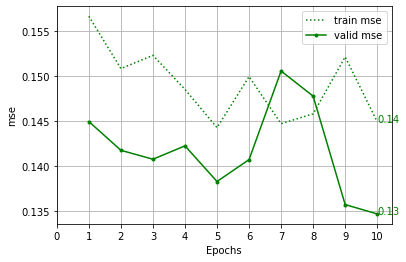

In [125]:
draw_mse([history], 1)